(solph-offset)=

# oemof-solph model with variable partload efficiency

- take coefficients from tespy model
- build offset transformer model
- apply coefficients with interpolation on temperature curve
- compare results with previous part load model without the part load efficiency

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utilities import load_temperature_data

input_data = load_temperature_data().head(24*2).tail(24)


# A crude demand model should be enough for us. Let the demand be 500 W per K below 15 °C.
input_data["Heat load (kW)"] = (0.5 * (15 - 0.1*input_data["Ambient temperature (d°C)"])).clip(lower=0)


In [2]:
from utilities import load_tespy_coefficients

tespy_coefficients = load_tespy_coefficients()

input_data["slope"] = input_data["Ambient temperature (d°C)"].map(tespy_coefficients["slope"])
input_data["offset"] = input_data["Ambient temperature (d°C)"].map(tespy_coefficients["offset"])



With respect to the previous version (solph-minimal-load), a the Transformer is replaced by an OffsetTransformer.

In [3]:
import oemof.solph as solph

hp_thermal_power = 9.1  # kW

slope = input_data["slope"][:-1]
offset = input_data["offset"][:-1]/1e3
demand = input_data["Heat load (kW)"][:-1]

es = solph.EnergySystem(timeindex=input_data.index, infer_last_interval=False)

b_electricity = solph.Bus(label="electricity")
b_heat_35C = solph.Bus(label="heat 35C")
es.add(b_electricity, b_heat_35C)

electricity_grid = solph.components.Source(
    label="electricity grid",
    outputs={b_electricity: solph.Flow(variable_costs=0.4)},  # €/kWh
)

heat_demand = solph.components.Sink(
    label="heat demand",
    inputs={b_heat_35C: solph.Flow(nominal_value=1, fix=demand)},  # kW
)
es.add(electricity_grid, heat_demand)


heat_pump = solph.components.OffsetTransformer(
        label=f"heat pump",
        inputs={b_electricity: solph.Flow(
            nominal_value=5,
            min=0.0,
            nonconvex=solph.NonConvex(),
        )},
        outputs={b_heat_35C: solph.Flow(
            nominal_value=hp_thermal_power,
            nonconvex=solph.NonConvex(),
            min=0.5,
        )},
        coefficients=[offset, slope]
)

es.add(heat_pump)

heating_rod = solph.components.Transformer(
    label="heating rod",
    inputs={b_electricity: solph.Flow()},
    outputs={b_heat_35C: solph.Flow()},
)

es.add(heating_rod)

thermal_storage = solph.components.GenericStorage(
    label='thermal_storage',
    inputs={b_heat_35C: solph.Flow()},
    outputs={b_heat_35C: solph.Flow()},
    loss_rate=0.02,
    nominal_storage_capacity=8.7,  # Assume 5 k of spread and 1.5 m³ volume 
)

es.add(thermal_storage)

model = solph.Model(energysystem=es)

model.solve()

results = solph.processing.results(model)



Electricity demand: 10.1 kWh


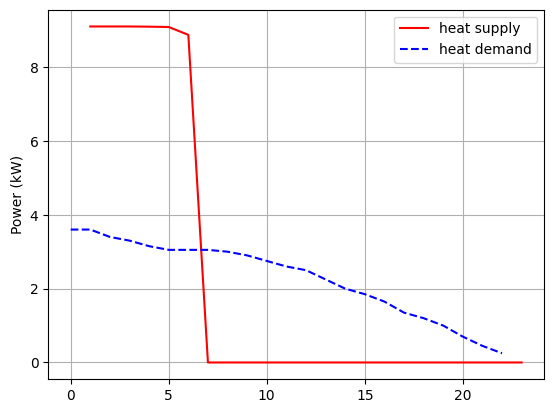

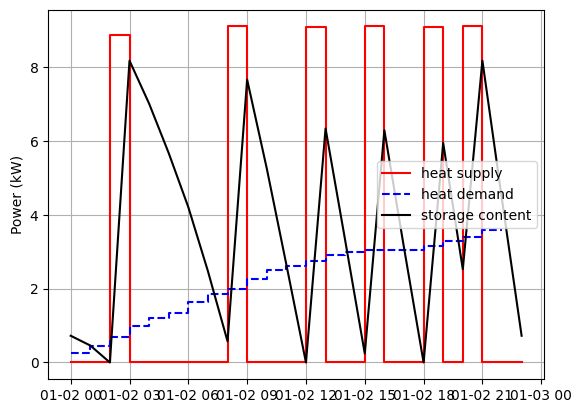

In [4]:
heat_supply = results[(heat_pump, b_heat_35C)]["sequences"]["flow"]
storage_content = results[(thermal_storage, None)]["sequences"]["storage_content"]

plt.plot(np.sort(heat_supply)[::-1], "r-", label="heat supply")
plt.plot(np.sort(demand)[::-1], "b--", label="heat demand")
plt.ylabel("Power (kW)")
plt.grid()
plt.legend()

plt.figure()
plt.plot(heat_supply, "r-", label="heat supply", drawstyle="steps-post")
plt.plot(demand, "b--", label="heat demand", drawstyle="steps-post")
plt.plot(storage_content, "k-", label="storage content")
plt.ylabel("Power (kW) or Energy (kWh)")
plt.grid()
plt.legend()

electricity_consumption = float(results[(electricity_grid, b_electricity)]["sequences"].sum())
print(f"Electricity demand: {electricity_consumption:.1f} kWh")
